In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
#from fastprogress import force_console_behavior
#import fastprogress
#fastai.basic_train.master_bar, fastai.basic_train.progress_bar = fastprogress.force_console_behavior()

In [3]:
def predict_single(img_file, learn):
    'function to take image and return prediction'
    classes = learn.data.classes
    prediction = learn.predict(open_image(img_file))
    probs_list = prediction[2].numpy()
    return {
        'category': classes[prediction[1].item()],
        'probs': {c: round(float(probs_list[i]), 5) for (i, c) in enumerate(classes)}
    }

In [5]:
path="chest_xray"
bs = 26
np.random.seed(42)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#defaults.device = device
defaults.device = device
print(defaults.device)

cuda:0


In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), 
                                  size=224, num_workers=0, 
                                  bs=bs, valid_pct=0.2).normalize(imagenet_stats)

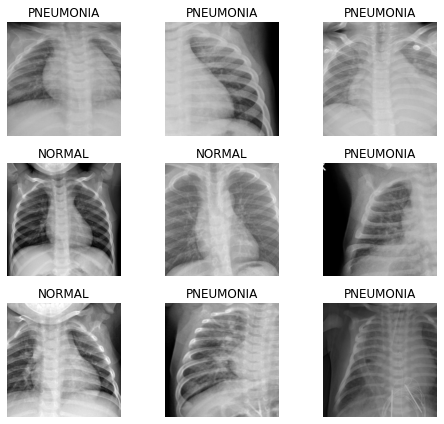

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
print(data.classes)
len(data.classes),data.c

['NORMAL', 'PNEUMONIA']


(2, 2)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir="models/tmp")

In [12]:
help(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data:fastai.basic_data.DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Union[Collection[int], NoneType]=None, ps:Union[float, Collection[float]]=0.5, custom_head:Union[torch.nn.modules.module.Module, NoneType]=None, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, bn_final:bool=False, init=<function kaiming_normal_ at 0x00000158D4E01A60>, concat_pool:bool=True, **kwargs:Any) -> fastai.basic_train.Learner
    Build convnet style learner.



In [9]:
learn.fit_one_cycle(4)

epoch     train_loss  valid_loss  error_rate  time    


KeyboardInterrupt: 

In [11]:
learn.save('stage-1_2')

In [10]:
learn.load('stage-1_2')

Learner(data=ImageDataBunch;

Train: LabelList (9367 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: chest_xray;

Valid: LabelList (2341 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [26]:
learn.export(os.path.abspath('./models/tmp/stage-1_1.pkl'))

In [10]:
PATH   = "./models/tmp"
MODEL  = "stage-1_2.pkl"
learn = load_learner(os.path.abspath(PATH), MODEL)

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

In [10]:
losses, idx = interp.top_losses()
print(f"{losses}  {idx}")

tensor([5.8326e+00, 5.6764e+00, 5.6065e+00,  ..., 1.1921e-06, 1.1921e-06,
        1.0729e-06])  tensor([ 220, 1392,   45,  ...,  563, 1569,  181])


In [22]:
len(data.valid_ds)==len(losses)==len(idx)

True

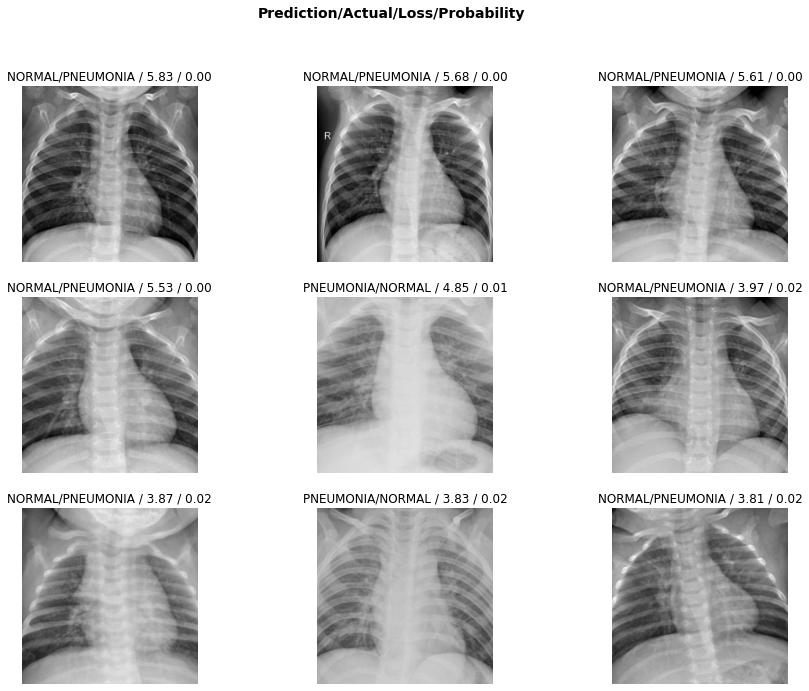

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

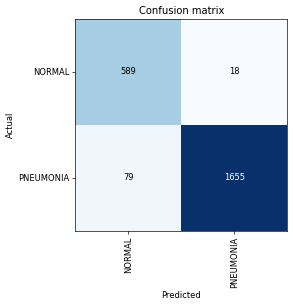

In [39]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [7]:
learn.unfreeze()

In [13]:
learn.lr_find()

epoch     train_loss  valid_loss  error_rate  time    
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

C:\Users\Tenagrim\anaconda3\envs\fast\lib\site-packages\fastai\sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


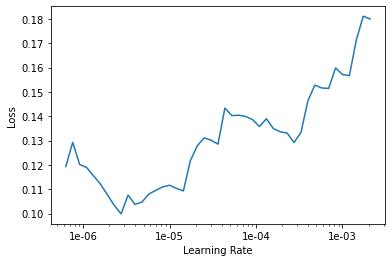

In [9]:
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-06,1e-05))

epoch     train_loss  valid_loss  error_rate  time    


KeyboardInterrupt: 

PNEUMONIA
tensor([0.2657, 0.7343])


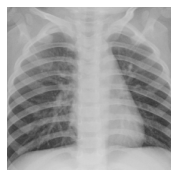

In [23]:
img = open_image(os.path.abspath('./test/n4.jpeg'))
img = img.apply_tfms(tfms=get_transforms()[1], size=224, resize_method=1)
img.show()
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class.obj)

print(outputs)


PNEUMONIA
tensor([0.0616, 0.9384])


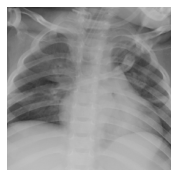

In [27]:
img = open_image(os.path.abspath('./test/p4.jpeg'))
img = img.apply_tfms(tfms=get_transforms()[1], size=224, resize_method=1)
img.show()
pred_class, pred_idx, outputs = learn.predict(img)
print(pred_class.obj)

print(outputs)


{'category': 'PNEUMONIA', 'probs': {'NORMAL': 0.46774, 'PNEUMONIA': 0.53226}}


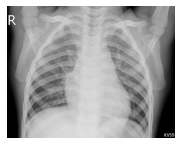

In [20]:
file = 'test/n3.jpeg'
img = open_image(os.path.abspath('./'+file))
img.show()
print(predict_single(file, learn))